In [50]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import unicodedata
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Configuration pour l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [51]:
df = pd.read_csv("Data/eleves.csv")
df[
    [
        "Texte_objectif_comm_ecrit",
        "Raison_gene_autre",
        "Pref_ecrit_oral_texte",
        "Besoin_comm_oral_text",
        "Motiv_text",
        "Commentaire_libre",
    ]
].fillna("")

,Texte_objectif_comm_ecrit,Raison_gene_autre,Pref_ecrit_oral_texte,Besoin_comm_oral_text,Motiv_text,Commentaire_libre
0,,,,,,
1,,,,,,
2,,,J’aime le fait que les professeurs prennent le...,,parce que,
3,,,,,,
4,,,,,,
...,...,...,...,...,...,...
1647,,,,,car j'ai déjà confiance en mes capacité,
1648,encouragement,,car il y a que moi qui peut les lire donc tout...,,des fois c'est mal formulé,Mme Parinet classe les notes par exemple elle ...
1649,,,je ne sais pas,,,j`aime votre logbook
1650,sans savoir pourquoi,"cest comme si on critiquait mon travail, comme...",car a l'oral quand ils sont bienveillant ca m'...,,car ils faudraient m'aider pas me rabaisser,je crois que j'ai tout dis


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata
import re
import nltk


class AnalyseurTexte:
    """
    Classe pour analyser des réponses textuelles et générer des nuages de mots
    """

    def __init__(
        self,
        df,
        colonne,
        utiliser_nltk=True,
        min_df=2,
        max_features=200,
        freq_min_affichage=3,
        ngram_range=(1, 2),
        titre=None,
    ):
        """
        Initialise l'analyseur de texte

        Paramètres:
        -----------
        df : DataFrame
            Le dataframe contenant les données
        colonne : str
            Le nom de la colonne à analyser
        utiliser_nltk : bool
            Utiliser la liste de stopwords de NLTK (recommandé)
        min_df : int
            Fréquence minimale d'apparition des termes
        max_features : int
            Nombre maximum de termes à extraire
        freq_min_affichage : int
            Fréquence minimale pour afficher un terme
        ngram_range : tuple
            (min, max) pour les n-grammes. Ex: (1,2) = mots simples + bigrammes
        titre : str, optional
            Titre personnalisé pour le nuage de mots
        """
        self.df = df.copy()
        self.colonne = colonne
        self.min_df = min_df
        self.max_features = max_features
        self.freq_min_affichage = freq_min_affichage
        self.ngram_range = ngram_range
        self.titre = titre

        # Initialiser les stopwords
        if utiliser_nltk:
            try:
                nltk.download("stopwords", quiet=True)
                from nltk.corpus import stopwords

                self.mots_vides = set(stopwords.words("french"))
            except:
                print("⚠️ NLTK non disponible, utilisation de la liste basique")
                self.mots_vides = self._get_stopwords_basiques()
        else:
            self.mots_vides = self._get_stopwords_basiques()

        # Ajouter des mots personnalisés
        mots_supplementaires = [
            "si",
            "ça",
            "ca",
            "peut",
            "doit",
            "etre",
            "avoir",
            "faire",
            "va",
            "fait",
            "faut",
            "deux",
            "trois",
            "aussi",
            "beaucoup",
            "lia",
            "dia",
            "l'ia",
            "eleves",
            "eleve",
            "comme",
            "car",
            "parce",
            "donc",
            "alors",
            "cela",
            "celui",
            "celle",
            "ceux",
            "celles",
            "quand",
            "avant",
            "apres",
            "après",
            "pendant",
            "depuis",
        ]
        self.mots_vides.update(mots_supplementaires)

        # IMPORTANT: Normaliser tous les stopwords (enlever les accents)
        self.mots_vides_normalises = set()
        for mot in self.mots_vides:
            mot_normalise = self._normaliser_mot(mot)
            self.mots_vides_normalises.add(mot_normalise)
            # Ajouter aussi la version originale au cas où
            self.mots_vides_normalises.add(mot)

        # Attributs pour stocker les résultats
        self.dict_termes = None
        self.statistiques = None

    def _normaliser_mot(self, mot):
        """Normalise un mot en enlevant les accents"""
        mot = mot.lower()
        mot = (
            unicodedata.normalize("NFKD", mot).encode("ASCII", "ignore").decode("utf-8")
        )
        return mot

    def _get_stopwords_basiques(self):
        """Retourne une liste basique de stopwords français"""
        return set(
            [
                # Articles
                "le",
                "la",
                "les",
                "un",
                "une",
                "des",
                "de",
                "du",
                # Conjonctions
                "et",
                "ou",
                "mais",
                "donc",
                "or",
                "ni",
                "car",
                "parce",
                # Verbes être et avoir
                "est",
                "sont",
                "ete",
                "être",
                "etre",
                "suis",
                "es",
                "sommes",
                "etes",
                "etait",
                "était",
                "etaient",
                "étaient",
                "sera",
                "seront",
                "a",
                "ont",
                "ai",
                "as",
                "avons",
                "avez",
                "avoir",
                "eu",
                "eus",
                "eut",
                "avait",
                "avaient",
                "aura",
                "auront",
                # Prépositions
                "pour",
                "dans",
                "sur",
                "avec",
                "par",
                "sans",
                "sous",
                "vers",
                "chez",
                "entre",
                "parmi",
                "selon",
                "malgre",
                "malgré",
                # Pronoms
                "ce",
                "ces",
                "je",
                "tu",
                "il",
                "elle",
                "nous",
                "vous",
                "ils",
                "elles",
                "me",
                "te",
                "se",
                "leur",
                "lui",
                "moi",
                "toi",
                "soi",
                "eux",
                "mon",
                "ma",
                "mes",
                "ton",
                "ta",
                "tes",
                "son",
                "sa",
                "ses",
                "notre",
                "nos",
                "votre",
                "vos",
                "leur",
                "leurs",
                "celui",
                "celle",
                "ceux",
                "celles",
                "ceci",
                "cela",
                "ça",
                "ca",
                # Autres mots courants
                "au",
                "aux",
                "qui",
                "que",
                "quoi",
                "dont",
                "où",
                "ou",
                "très",
                "tres",
                "plus",
                "moins",
                "bien",
                "mal",
                "ne",
                "pas",
                "non",
                "oui",
                "tout",
                "tous",
                "toute",
                "toutes",
                "faire",
                "fait",
                "faite",
                "faits",
                "faites",
                "avoir",
                "ayant",
                "eu",
                "eue",
                "eus",
                "eues",
                "comme",
                "ainsi",
                "alors",
                "donc",
                "cependant",
                "néanmoins",
                "aussi",
                "encore",
                "deja",
                "déjà",
                "jamais",
                "toujours",
                "souvent",
                "parfois",
                "quelques",
                "plusieurs",
                "autre",
                "autres",
            ]
        )

    def nettoyer_texte(self, texte):
        """Nettoie et normalise le texte en gardant les apostrophes"""
        if pd.isna(texte):
            return ""

        texte = str(texte).lower()

        # Normaliser les différents types d'apostrophes vers '
        texte = texte.replace(""", "'").replace(""", "'").replace("`", "'")
        texte = texte.replace("'", "'").replace("'", "'")

        # Supprimer les accents SAUF pour les apostrophes
        texte = (
            unicodedata.normalize("NFKD", texte)
            .encode("ASCII", "ignore")
            .decode("utf-8")
        )

        # Supprimer la ponctuation SAUF les apostrophes et les espaces
        texte = re.sub(r"[^\w\s']", " ", texte)

        # Supprimer les apostrophes isolées
        texte = re.sub(r"\s'\s", " ", texte)
        texte = re.sub(r"^'|'$", "", texte)

        # Nettoyer les espaces multiples
        texte = re.sub(r"\s+", " ", texte).strip()

        return texte

    def calculer_statistiques(self):
        """Calcule les statistiques descriptives sur les textes"""
        # Gérer les valeurs manquantes
        self.df[self.colonne] = self.df[self.colonne].fillna("")

        # Calculer les métriques
        self.df["longueur"] = self.df[self.colonne].astype(str).apply(len)
        self.df["nb_mots"] = (
            self.df[self.colonne].astype(str).apply(lambda x: len(x.split()))
        )

        self.statistiques = {
            "nb_reponses": len(self.df),
            "longueur_moyenne": self.df["longueur"].mean(),
            "longueur_mediane": self.df["longueur"].median(),
            "nb_mots_moyen": self.df["nb_mots"].mean(),
            "reponses_vides": (self.df[self.colonne] == "").sum(),
        }

        return self.statistiques

    def extraire_termes(self):
        """Extrait et filtre les termes (mots simples et n-grammes)"""
        # Nettoyer les textes
        self.df["texte_nettoye"] = self.df[self.colonne].apply(self.nettoyer_texte)

        # Utiliser les stopwords normalisés pour CountVectorizer
        vectorizer = CountVectorizer(
            ngram_range=self.ngram_range,
            stop_words=list(self.mots_vides_normalises),
            min_df=self.min_df,
            max_features=self.max_features,
            token_pattern=r"\b\w+(?:'\w+)?\b",
        )

        X = vectorizer.fit_transform(self.df["texte_nettoye"])
        termes = vectorizer.get_feature_names_out()
        frequences = X.sum(axis=0).A1

        # Filtrer les termes pertinents ET vérifier manuellement les stopwords
        self.dict_termes = {}
        for terme, freq in zip(termes, frequences):
            # Vérifier que le terme n'est pas dans les stopwords normalisés
            if terme.lower() in self.mots_vides_normalises:
                continue

            if freq >= self.freq_min_affichage and len(terme) >= 3:
                if " " in terme:  # Bigramme
                    mots = terme.split()
                    # Vérifier que les mots du bigramme ne sont pas des stopwords
                    if any(mot.lower() in self.mots_vides_normalises for mot in mots):
                        continue
                    if all(len(mot) >= 3 for mot in mots):
                        self.dict_termes[terme] = freq
                else:  # Mot simple
                    self.dict_termes[terme] = freq

        return self.dict_termes

    def afficher_nuage_mots(
        self, largeur=1400, hauteur=700, colormap="viridis", titre=None
    ):
        """
        Génère et affiche le nuage de mots

        Paramètres:
        -----------
        largeur : int
            Largeur du nuage de mots
        hauteur : int
            Hauteur du nuage de mots
        colormap : str
            Palette de couleurs à utiliser
        titre : str, optional
            Titre à afficher (prioritaire sur le titre défini dans __init__)
        """
        if self.dict_termes is None:
            raise ValueError(
                "Vous devez d'abord extraire les termes avec extraire_termes()"
            )

        wordcloud = WordCloud(
            width=largeur,
            height=hauteur,
            background_color="white",
            colormap=colormap,
            relative_scaling=0.5,
            min_font_size=10,
        ).generate_from_frequencies(self.dict_termes)

        plt.figure(figsize=(18, 9))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

        # Utiliser le titre passé en paramètre, sinon celui de l'init, sinon un titre par défaut
        if titre is None:
            titre = (
                self.titre
                if self.titre is not None
                else f"Nuage de mots - {self.colonne}"
            )
        plt.title(titre, fontsize=20, pad=20)
        plt.tight_layout()
        plt.show()

    def afficher_top_termes(self, n=30):
        """Affiche les termes les plus fréquents"""
        if self.dict_termes is None:
            raise ValueError(
                "Vous devez d'abord extraire les termes avec extraire_termes()"
            )

        print(f"\nNombre de termes retenus : {len(self.dict_termes)}")
        print(f"\n=== Top {n} des termes les plus fréquents ===")

        termes_tries = sorted(
            self.dict_termes.items(), key=lambda x: x[1], reverse=True
        )[:n]
        for terme, freq in termes_tries:
            type_terme = "bigramme" if " " in terme else "mot simple"
            print(f"{terme:.<40} {int(freq):>4} ({type_terme})")

    def analyser(
        self,
        afficher_stats=True,
        afficher_nuage=True,
        afficher_top=True,
        n_top=30,
        titre=None,
    ):
        """
        Effectue l'analyse complète en un seul appel

        Paramètres:
        -----------
        afficher_stats : bool
            Afficher les statistiques descriptives
        afficher_nuage : bool
            Afficher le nuage de mots
        afficher_top : bool
            Afficher la liste des termes fréquents
        n_top : int
            Nombre de termes à afficher dans le top
        titre : str, optional
            Titre personnalisé pour le nuage de mots
        """
        # Calculer les statistiques
        stats = self.calculer_statistiques()
        if afficher_stats:
            print("=== Statistiques sur les réponses ===")
            print(f"Nombre de réponses : {stats['nb_reponses']}")
            print(f"Longueur moyenne : {stats['longueur_moyenne']:.2f} caractères")
            print(f"Longueur médiane : {stats['longueur_mediane']:.2f} caractères")
            print(f"Nombre moyen de mots : {stats['nb_mots_moyen']:.2f}")
            print(f"Réponses vides : {stats['reponses_vides']}")

        # Extraire les termes
        self.extraire_termes()

        # Afficher le nuage avec le titre personnalisé
        if afficher_nuage:
            self.afficher_nuage_mots(titre=titre)

        # Afficher le top
        if afficher_top:
            self.afficher_top_termes(n=n_top)

        return self.dict_termes, self.statistiques

=== Statistiques sur les réponses ===
Nombre de réponses : 1652
Longueur moyenne : 2.78 caractères
Longueur médiane : 0.00 caractères
Nombre moyen de mots : 0.53
Réponses vides : 1499


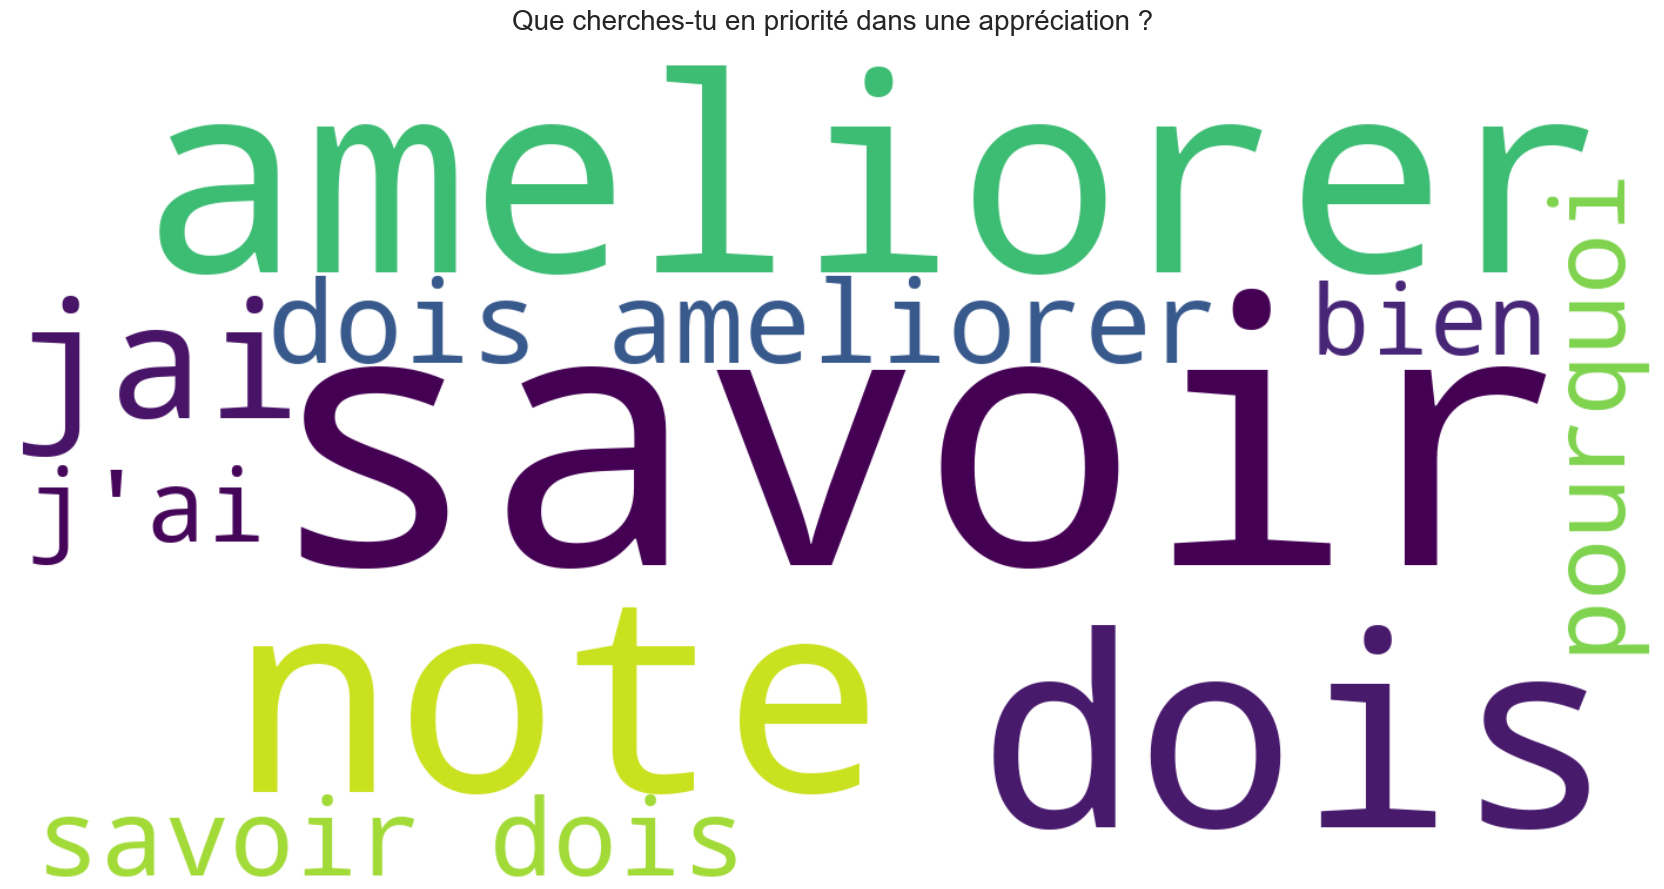


Nombre de termes retenus : 10

=== Top 50 des termes les plus fréquents ===
savoir..................................   58 (mot simple)
ameliorer...............................   29 (mot simple)
note....................................   29 (mot simple)
dois....................................   28 (mot simple)
jai.....................................   26 (mot simple)
dois ameliorer..........................   24 (bigramme)
savoir dois.............................   24 (bigramme)
pourquoi................................   22 (mot simple)
j'ai....................................   21 (mot simple)
bien....................................   20 (mot simple)


In [66]:
analyseur = AnalyseurTexte(
    df=df,
    colonne="Texte_objectif_comm_ecrit",
    min_df=10,  # Fréquence minimale
    max_features=10,  # Nombre max de termes
    freq_min_affichage=10,  # Fréquence min pour l'affichage
    ngram_range=(1, 2),  # Mots simples + bigrammes + trigrammes
    titre="Que cherches-tu en priorité dans une appréciation ?",
)

# Analyse complète
dict_termes, stats = analyseur.analyser(n_top=50)

=== Statistiques sur les réponses ===
Nombre de réponses : 1652
Longueur moyenne : 2.18 caractères
Longueur médiane : 0.00 caractères
Nombre moyen de mots : 0.41
Réponses vides : 1572


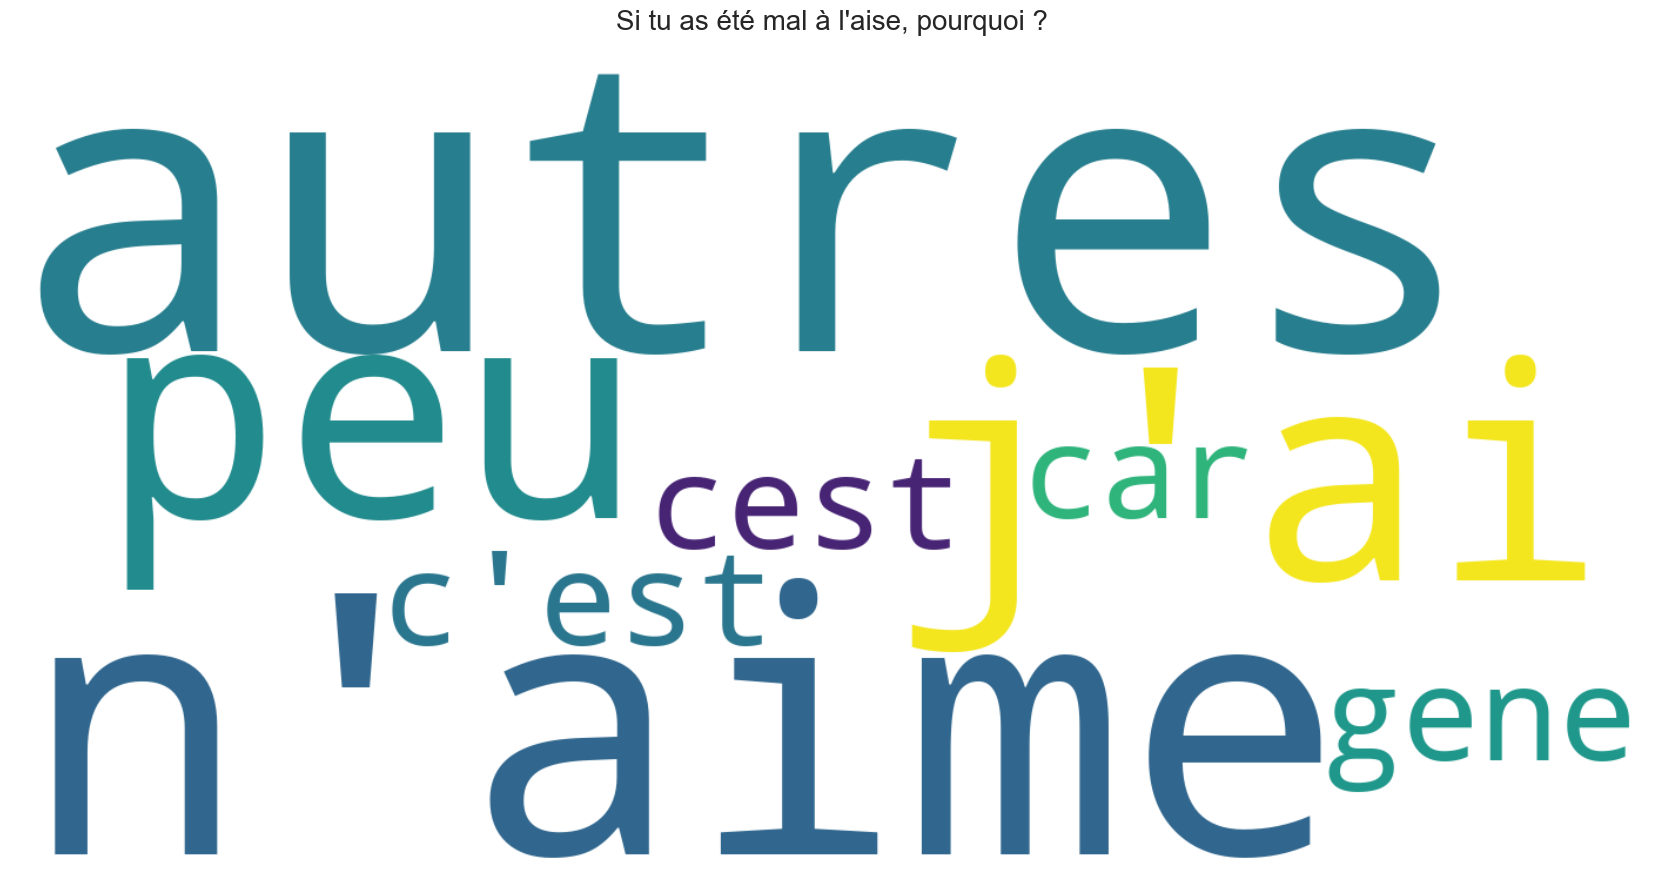


Nombre de termes retenus : 8

=== Top 50 des termes les plus fréquents ===
autres..................................   10 (mot simple)
n'aime..................................    8 (mot simple)
j'ai....................................    7 (mot simple)
peu.....................................    7 (mot simple)
c'est...................................    6 (mot simple)
car.....................................    6 (mot simple)
cest....................................    6 (mot simple)
gene....................................    6 (mot simple)


In [63]:
analyseur = AnalyseurTexte(
    df=df,
    colonne="Raison_gene_autre",
    min_df=2,  # Fréquence minimale
    max_features=10,  # Nombre max de termes
    freq_min_affichage=2,  # Fréquence min pour l'affichage
    ngram_range=(1, 2),  # Mots simples + bigrammes + trigrammes
    titre="Si tu as été mal à l'aise, pourquoi ?",
)

# Analyse complète
dict_termes, stats = analyseur.analyser(n_top=50)

=== Statistiques sur les réponses ===
Nombre de réponses : 1652
Longueur moyenne : 33.71 caractères
Longueur médiane : 24.00 caractères
Nombre moyen de mots : 6.39
Réponses vides : 451


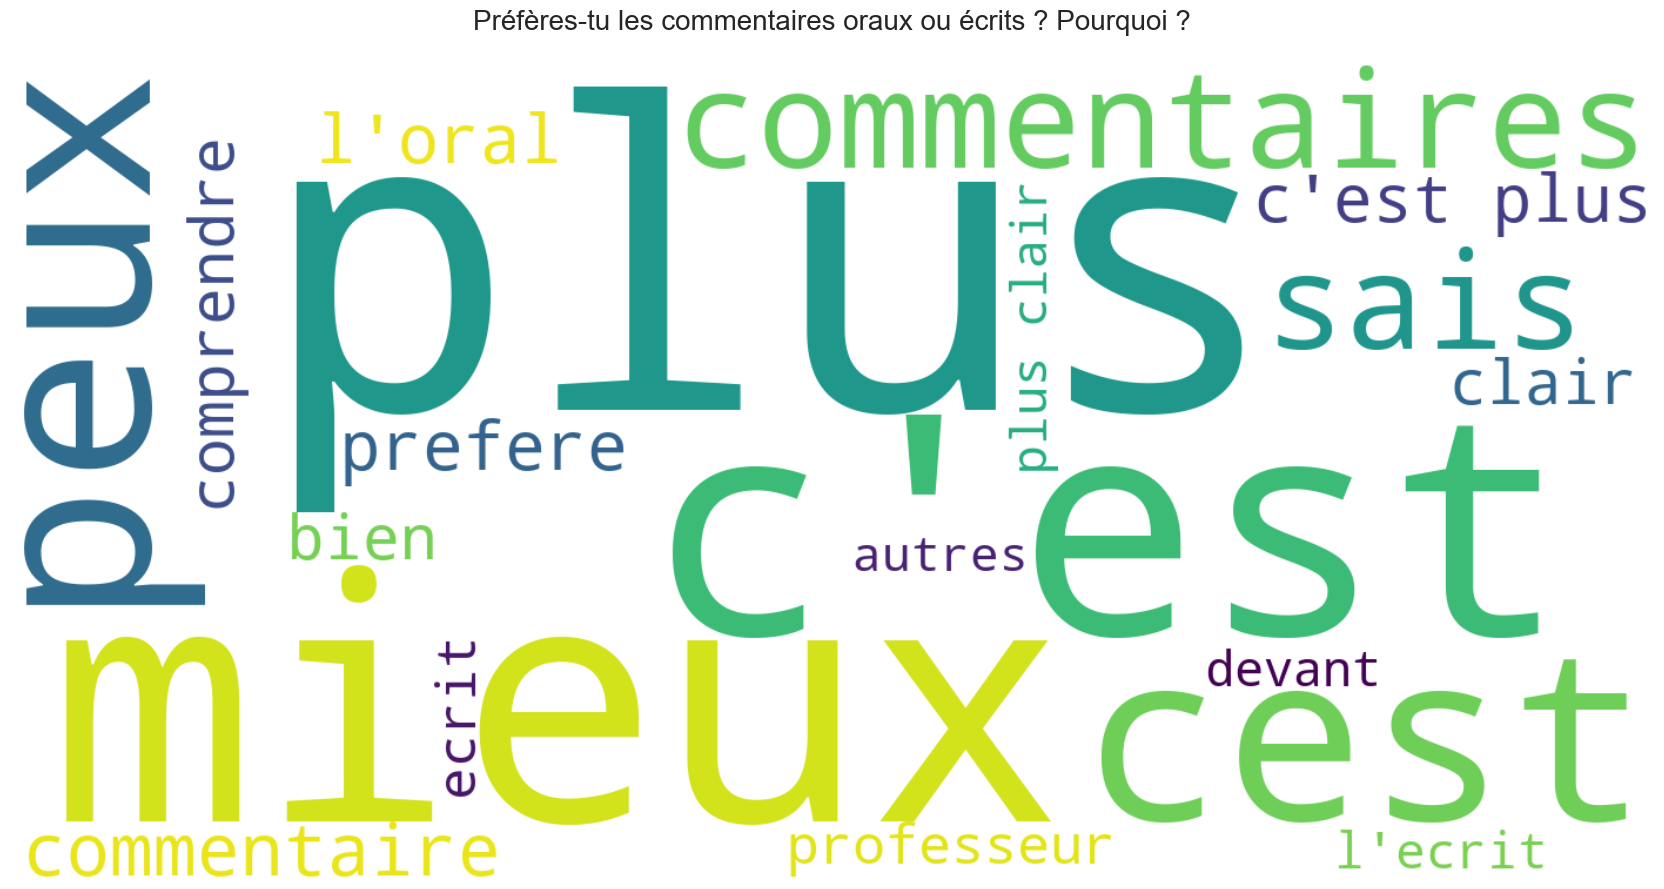


Nombre de termes retenus : 20

=== Top 50 des termes les plus fréquents ===
plus....................................  300 (mot simple)
mieux...................................  177 (mot simple)
c'est...................................  173 (mot simple)
cest....................................   93 (mot simple)
peux....................................   88 (mot simple)
commentaires............................   83 (mot simple)
sais....................................   81 (mot simple)
commentaire.............................   78 (mot simple)
l'oral..................................   70 (mot simple)
prefere.................................   69 (mot simple)
c'est plus..............................   65 (bigramme)
bien....................................   59 (mot simple)
clair...................................   59 (mot simple)
comprendre..............................   59 (mot simple)
professeur..............................   59 (mot simple)
ecrit...................................

In [68]:
analyseur = AnalyseurTexte(
    df=df,
    colonne="Pref_ecrit_oral_texte",
    min_df=10,  # Fréquence minimale
    max_features=20,  # Nombre max de termes
    freq_min_affichage=15,  # Fréquence min pour l'affichage
    ngram_range=(1, 3),  # Mots simples + bigrammes + trigrammes
    titre="Préfères-tu les commentaires oraux ou écrits ? Pourquoi ?",
)

# Analyse complète
dict_termes, stats = analyseur.analyser(n_top=50)

In [76]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd


class AnalyseurEmbeddings:
    def __init__(self, df, colonne, n_clusters=5):
        self.df = df.copy()
        self.colonne = colonne
        self.n_clusters = n_clusters
        self.model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

    def analyser(self):
        # Nettoyer les textes
        texts = self.df[self.colonne].fillna("").astype(str).tolist()
        texts = [t for t in texts if len(t) > 10]

        # Créer les embeddings
        embeddings = self.model.encode(texts)

        # Clustering
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings)

        # Analyser chaque cluster
        results = []
        for i in range(self.n_clusters):
            cluster_texts = [texts[j] for j in range(len(texts)) if clusters[j] == i]
            results.append(
                {
                    "cluster": f"Groupe {i+1}",
                    "taille": len(cluster_texts),
                    "exemple": cluster_texts[0][:200] if cluster_texts else "",
                }
            )

        return pd.DataFrame(results)

c:\Users\mle-mentec\AppData\Local\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
analyseur = AnalyseurEmbeddings(
    df=df, colonne="Pref_ecrit_oral_texte",
    n_clusters=10)
analyseur.analyser()

c:\Users\mle-mentec\AppData\Local\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,cluster,taille,exemple
0,Groupe 1,107,Les oraux m'angoisse
1,Groupe 2,126,Parce que c’est pareil
2,Groupe 3,60,je ne sais pas
3,Groupe 4,109,Car c'est clair
4,Groupe 5,112,je trouve ça mieux
5,Groupe 6,105,Car mes camarades ne peuvent pas voir
6,Groupe 7,188,"Je n’ai pas vraiment d’explications à donner, ..."
7,Groupe 8,122,J’aime le fait que les professeurs prennent le...
8,Groupe 9,97,Cela dépend des commentaires
9,Groupe 10,129,car c'est plus personnel


In [ ]:
analyseur = AnalyseurEmbeddings(df=df, colonne="Motiv_text", n_clusters=5)
analyseur.analyser()

c:\Users\mle-mentec\AppData\Local\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,cluster,taille,exemple
0,Groupe 1,92,car j'ai envie d'avoir un meilleur commentaire...
1,Groupe 2,223,Cela me pousse à réussir.
2,Groupe 3,126,Ne sais pas quoi repondre
3,Groupe 4,29,J'ai eu une mauvaise expérience avec un profes...
4,Groupe 5,74,Je ne sais pas


In [80]:
analyseur = AnalyseurEmbeddings(df=df, colonne="Commentaire_libre", n_clusters=5)
analyseur.analyser()

c:\Users\mle-mentec\AppData\Local\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,cluster,taille,exemple
0,Groupe 1,10,"ils sont gentils, et essaye vraiment de m'aide..."
1,Groupe 2,85,Ils faut réussir à être moins sec quand certai...
2,Groupe 3,59,respecter et avoir une facon de parler aux ele...
3,Groupe 4,59,Motivé au lieu de rabaisser
4,Groupe 5,76,"non , tout a été dit je suppose"


In [81]:
analyseur = AnalyseurEmbeddings(df=df, colonne="Raison_gene_autre", n_clusters=5)
analyseur.analyser()

c:\Users\mle-mentec\AppData\Local\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,cluster,taille,exemple
0,Groupe 1,13,J'aime pas que cela est dit a voit haute
1,Groupe 2,11,Je n'ai pas à faire à des commentaires oraux d...
2,Groupe 3,6,"c'est un commentaire positif, mais ça me gêne ..."
3,Groupe 4,37,remarques des autres camarades (suite à un 21/20)
4,Groupe 5,5,je sais pas
